In [1]:
import pandas as pd
import numpy as np
from nilmtk.datastore import Key
from nilmtk.utils import check_directory_exists, get_datastore, get_module_directory
from nilm_metadata import convert_yaml_to_hdf5

In [2]:
def convert_data(file_name):
    '''
    Parameters
    ------------
    Takes input file name to be tested as string.
    Data columns should contain following values ['timestamp','R','A','C','F','V','T']
    Converts it into hdf5 Format.
    '''
    df = pd.read_csv(f'{file_name}',names =['timestamp','R','A','C','F','V','T'])
    column_mapping = {
        'F': ('frequency', ""),
        'V': ('voltage', ""),
        'T': ('power', 'active'),
        'C': ('current', ''),
        'R': ('power', 'reactive'),
        'A': ('power', 'apparent'),
    }

    TIMESTAMP_COLUMN_NAME = "timestamp"
    TIMEZONE = "Asia/Kolkata"
    FREQ = "1T"
#     output_name = file_name.split(sep='.')[0]
    LEVEL_NAMES = ['physical_quantity', 'type']
    output_filename = 'test.h5'

    # Open data store
    store = get_datastore(output_filename, format='HDF', mode='w')
    key = Key(building=1, meter=1)
    print('Loading ', 1)
    df.index = pd.to_datetime(df.timestamp.values)
    df = df.tz_convert(TIMEZONE)
    df = df.drop(TIMESTAMP_COLUMN_NAME, 1)
    df.index = pd.to_datetime(df.index.values)
    df.columns = pd.MultiIndex.from_tuples(
                [column_mapping[x] for x in df.columns],
                names=LEVEL_NAMES
            )
    df = df.apply(pd.to_numeric, errors='ignore')
    df = df.dropna()
    df = df.astype(np.float32)
    df = df.sort_index()
    df = df.resample("1T").mean()
    assert df.isnull().sum().sum() == 0
    store.put(str(key), df)
    store.close()
    convert_yaml_to_hdf5('./metadata', output_filename)

    print("Done converting test data to HDF5!")
    return

In [3]:
convert_data('ac_seconds4.csv')

Loading  1
Done converting YAML metadata to HDF5!
Done converting test data to HDF5!


In [4]:
from combinatorial_optimisation import CO
from fhmm_exact import FHMMExact

In [5]:
experiment1 = {
'power': {'mains': ['apparent','active'],'appliance': ['apparent','active']},
  'sample_rate': 60,
  'appliances': ['air conditioner','fridge'],
  'methods': {"CO":CO({})},
  'train': {    
    'datasets': {
        'iAWE': {
            'path': './iAWE.h5',
            'buildings': {
                1: {
                    'start_time': '2013-07-13', 
                    'end_time': '2013-08-04'
                    }
                }                
            }
        }
    },
  'test': {
    'datasets': {
        'CAXE': {
            'path': './test.h5',
            'buildings': {
                1: {
                    'start_time': '2020-08-12',
                    'end_time': '2020-08-14'
                    }
                }
            }
        },
        'metrics':['rmse']
    }
}

In [6]:
from api import API

Joint Testing for all algorithms
Loading data for  CAXE  dataset
Dropping missing values
Generating predictions for : CO
...............CO disaggregate_chunk running.............


C:\Users\Faizan\anaconda3\envs\nilmtk-env\lib\site-packages\nilmtk\metergroup.py:86: RuntimeWarning: Building 1 has an empty 'appliances' list.
  .format(building_id.instance), RuntimeWarning)


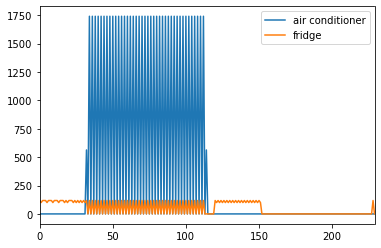

In [7]:
api_results_experiment_1 = API(experiment1)